In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG960.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,1.738898,-0.182527,0.400638,-0.972492,-0.972492,-0.163114,1.762586,0.419585,1.498572,-0.314370,2.025625,-0.449462,1.815617,-0.076696,-0.151385,1.017895,-0.901444,-0.227696,1.412222,1.395096,0.923513,0.991772,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,4.004890,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0
1,-0.584556,-0.058123,-1.179441,1.937525,1.937525,-0.577803,-0.584252,-0.595731,-1.066401,-0.687793,1.256559,0.436874,-0.285566,-0.076696,-0.151385,-0.405909,-0.972438,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,-0.249695,-0.763077,3.386554,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,0.0
2,-0.879411,-0.278223,-0.291066,0.085696,0.085696,0.602136,-0.818236,-0.934170,-1.144127,-0.600710,0.487493,-0.449462,-0.866744,-0.076696,-0.151385,-0.405909,0.187142,-0.227696,1.412222,1.395096,1.571250,-1.657233,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,1.310483,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,0.0
3,0.335390,-0.038984,0.078811,-0.707945,-0.707945,-0.577803,0.323572,-0.088073,0.565854,-0.321111,2.794691,3.095885,-0.866744,-0.076696,-0.151385,1.017895,-0.463643,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,4.482467,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0
4,1.833252,-0.259084,0.530262,4.053900,4.053900,-0.577803,1.801624,-0.934170,-0.133684,-0.688924,1.256559,-0.449462,-0.866744,-0.076696,-0.151385,-0.405909,-1.303747,-0.227696,1.412222,0.013276,0.599644,-0.862531,-0.032332,-0.914655,2.861821,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,4.567605,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0


In [4]:
data.shape

(4788, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    3684
0.0    1104
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(4788, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77453027 0.76304802 0.76826722 0.77115987 0.76593521]
0.7685881200602964


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  35, 1069],
       [  39, 3645]])

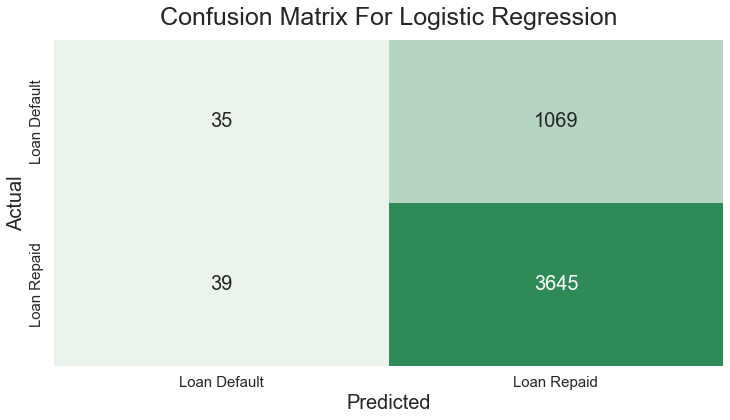

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7685881370091896

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

3645
1069
39
35
0.7685881370091896


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    3684
0.0    1104
Name: loan_status_bin, dtype: int64

0.7694235588972431


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7732286805260925

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77453027 0.76304802 0.76826722 0.77115987 0.76593521]
0.7685881200602964


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  35, 1069],
       [  39, 3645]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.50332473, 0.49667527],
       [0.26255878, 0.73744122],
       [0.28630861, 0.71369139],
       ...,
       [0.26614953, 0.73385047],
       [0.30334261, 0.69665739],
       [0.38480892, 0.61519108]])

In [24]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.80).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 804,  300],
       [1901, 1783]])

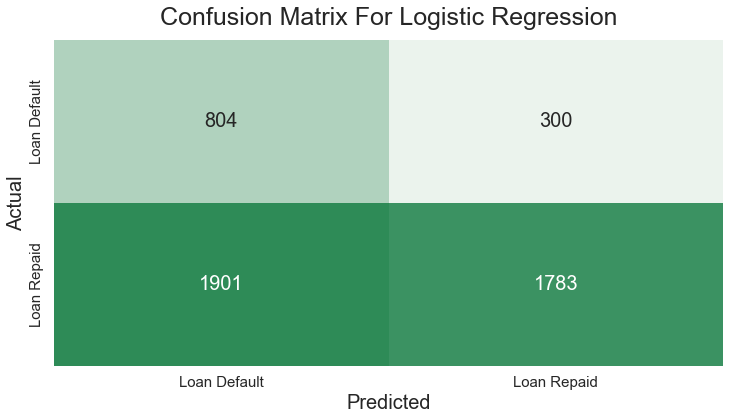

In [26]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [27]:
accuracy_score(y, y_pred_success)

0.5403091060985797

In [28]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1783
300
1901
804
0.5403091060985797


In [29]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8559769563130101

In [30]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.9186046511627907
91


In [31]:
PosPredVal

[0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7693753916858157,
 0.7693753916858157,
 0.7693753916858157,
 0.7693753916858157,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7694879832810867,
 0.7693915952331173,
 0.7695524884985362,
 0.7695524884985362,
 0.7695524884985362,
 0.7696170747018205,
 0.7695688572624529,
 0.7697947214076246,
 0.769907795473596,
 0.7705536912751678,
 0.7710084033613446,
 0.7716750841750841,
 0.77227722772

In [32]:
#Obtaining classification based on desired threshold of 0.9: 

y_pred_success = (y_pred_prob[:, 1] > 0.90).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[1074,   30],
       [3353,  331]])

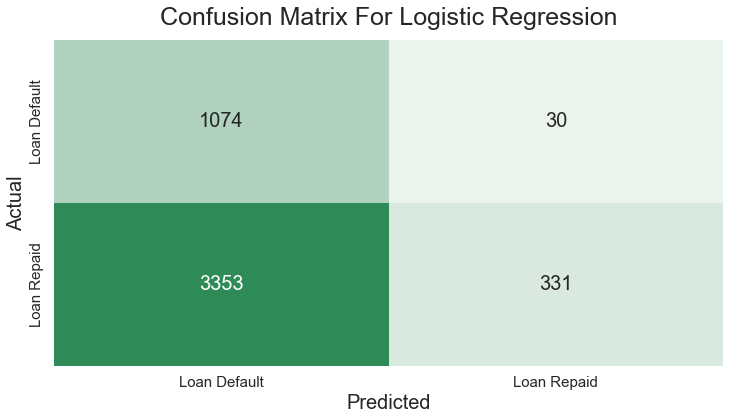

In [34]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 